# 06 — Decision Policy Layer: Confidence Gating + Agreement (USD/CAD)

Goal: Build decision-level logic on top of existing probabilistic direction outputs.
We focus on *selective prediction* (act vs abstain), and evaluate coverage vs reliability.

Inputs:
- outputs/usdcad_features_h7.parquet (from Notebook 03)

Outputs (written to outputs/, ignored by git):
- decision_predictions_h7.parquet  (per-date OOS predictions for logreg + tree)
- decision_policy_sweep.csv        (coverage vs metrics for multiple policies)
- decision_policy_by_regime.csv    (regime-conditional diagnostics)


In [39]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

def find_repo_root(start: Path | None = None) -> Path:
    if start is None:
        start = Path.cwd()
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "README.md").exists() and (p / "notebooks").exists():
            return p
    return start

REPO_ROOT = find_repo_root()
OUT_DIR = REPO_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

H = 7
FEATURE_PATH = OUT_DIR / f"usdcad_features_h{H}.parquet"
if not FEATURE_PATH.exists():
    raise FileNotFoundError(f"Feature parquet not found: {FEATURE_PATH}. Run Notebook 03 first.")

PRED_PATH = OUT_DIR / f"decision_predictions_h{H}.parquet"
SWEEP_CSV = OUT_DIR / "decision_policy_sweep.csv"
REGIME_CSV = OUT_DIR / "decision_policy_by_regime.csv"


In [40]:
df_feat = pd.read_parquet(FEATURE_PATH).sort_index()

target_col = f"direction_{H}d"
excluded = {target_col, f"fwd_return_{H}d"}

feature_cols = [c for c in df_feat.columns if c not in excluded]

X_all = df_feat[feature_cols].copy()
y_all = df_feat[target_col].astype(int).copy()

df_feat.shape, len(feature_cols), feature_cols[:10]


((1960, 23),
 21,
 ['value',
  'ret_1d',
  'ret_3d',
  'ret_5d',
  'ret_10d',
  'ret_21d',
  'vol_5d',
  'vol_10d',
  'vol_21d',
  'vol_63d'])

In [41]:
def assign_confidence_bucket(p: pd.Series, edges=(0.0, 0.4, 0.45, 0.55, 0.6, 1.0)) -> pd.Series:
    """
    Bucket by distance from 0.5:
    - low confidence: near 0.5
    - high confidence: closer to 0 or 1

    Uses edges on p directly (same convention as prior notebooks).
    """
    labels = [f"[{edges[i]:.2f},{edges[i+1]:.2f})" for i in range(len(edges) - 1)]
    return pd.cut(p, bins=edges, labels=labels, right=False, include_lowest=True)

def expected_calibration_error(y_true: np.ndarray, p_up: np.ndarray, n_bins: int = 10) -> float:
    """
    Simple ECE: bin by predicted probability, compare avg confidence vs empirical frequency.
    """
    y_true = y_true.astype(int)
    p_up = np.asarray(p_up)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ids = np.digitize(p_up, bins) - 1
    ids = np.clip(ids, 0, n_bins - 1)

    ece = 0.0
    n = len(p_up)
    for b in range(n_bins):
        mask = ids == b
        if not mask.any():
            continue
        frac = mask.mean()
        acc = y_true[mask].mean()
        conf = p_up[mask].mean()
        ece += frac * abs(acc - conf)
    return float(ece)


## Expanding-window monthly refit (same as 04/05)

We reproduce the same OOS protocol:

- At the start of each month: fit using all prior data (strictly before that month)
- Predict probabilities for all dates in that month
- Produce a per-date OOS table with:
  - y_true (direction)
  - p_up_logreg
  - p_up_tree


In [42]:
def rolling_monthly_backtest_proba(
    X: pd.DataFrame,
    y: pd.Series,
    model,
    min_train_size: int = 252 * 2,
) -> pd.DataFrame:
    """
    Expanding-window monthly refit:
    - Fit at the start of each month using all prior data (strictly before the month)
    - Predict probabilities for all dates in that month
    """
    idx = X.index
    months = pd.Series(idx.to_period("M"), index=idx)

    rows = []
    for m in months.unique():
        test_mask = months == m
        train_mask = months < m

        if train_mask.sum() < min_train_size:
            continue

        X_train = X.loc[train_mask]
        y_train = y.loc[train_mask]
        X_test = X.loc[test_mask]
        y_test = y.loc[test_mask]

        fitted = model
        fitted.fit(X_train, y_train)

        # p_up = P(y=1)
        p_up = fitted.predict_proba(X_test)[:, 1]

        out = pd.DataFrame(
            {
                "y_true": y_test.astype(int).values,
                "p_up": p_up,
            },
            index=X_test.index,
        )
        rows.append(out)

    bt = pd.concat(rows).sort_index() if rows else pd.DataFrame()
    return bt


In [43]:
logreg_model = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000,
        random_state=RANDOM_SEED
    ))
])

tree_model = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.05,
    max_iter=300,
    min_samples_leaf=20,
    random_state=RANDOM_SEED
)

logreg_model, tree_model


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(max_iter=2000, penalty='l2',
                                     random_state=7))]),
 HistGradientBoostingClassifier(learning_rate=0.05, max_depth=3, max_iter=300,
                                random_state=7))

In [44]:
bt_logreg = rolling_monthly_backtest_proba(X_all, y_all, model=logreg_model)
bt_tree = rolling_monthly_backtest_proba(X_all, y_all, model=tree_model)

# Align / merge
df_pred = bt_logreg.rename(columns={"p_up": "p_up_logreg"}).join(
    bt_tree.rename(columns={"p_up": "p_up_tree"})[["p_up_tree"]],
    how="inner",
)

# Add regime flags (from features) if present
for col in ["is_high_vol", "is_month_end", "day_of_week", "month"]:
    if col in df_feat.columns:
        df_pred[col] = df_feat.loc[df_pred.index, col]

df_pred.head(), df_pred.tail(), df_pred.shape


/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/ianvicente/Desktop/FX-Rate-Forecasting-Pipeline/.venv/lib/python3.12/site-packages/sklearn/linear_model/_

(            y_true  p_up_logreg  p_up_tree  is_high_vol  is_month_end  day_of_week  month
 obs_date                                                                                 
 2020-03-02       1     0.304194   0.568837            0             0            0      3
 2020-03-03       1     0.395651   0.761815            0             0            1      3
 2020-03-04       1     0.419486   0.576839            0             0            2      3
 2020-03-05       1     0.361288   0.675071            0             0            3      3
 2020-03-06       1     0.310306   0.562216            0             0            4      3,
             y_true  p_up_logreg  p_up_tree  is_high_vol  is_month_end  day_of_week  month
 obs_date                                                                                 
 2025-12-05       0     0.423402   0.757374            0             0            4     12
 2025-12-08       0     0.526680   0.887501            0             0            0     1

In [45]:
df_pred.to_parquet(PRED_PATH, index=True)

## Decision policies implemented

We evaluate three decision-level policies, all using out-of-sample probabilities from the same backtest protocol:

1) **Single-model threshold gating**
   - Act only when the model is sufficiently confident away from 0.5.
   - Abstain otherwise.

2) **Agreement threshold gating**
   - Act only when **logreg and tree** both (a) are confident and (b) predict the same direction.
   - We use **logreg probabilities** for probability scoring (logloss/Brier/ECE) to avoid tree miscalibration contaminating calibration metrics.

3) **Balanced top-k confidence**
   - Act on the top-k most confident predictions but **balanced across UP/DOWN tails** to avoid directional collapse.
   - This measures "what if we only act X% of the time?" in a stable way.


In [46]:
def apply_threshold_policy(p_up: pd.Series, t: float) -> pd.Series:
    """
    Symmetric abstain band around 0.5:
    - UP if p >= t
    - DOWN if p <= 1 - t
    - ABSTAIN otherwise
    Returns: +1 (UP), 0 (ABSTAIN), -1 (DOWN)
    """
    act = pd.Series(0, index=p_up.index, dtype=int)
    act[p_up >= t] = 1
    act[p_up <= (1.0 - t)] = -1
    return act

def y_to_signed(y_true: pd.Series) -> pd.Series:
    """y_true: 1=UP, 0=DOWN -> signed +1 / -1"""
    return y_true.astype(int).replace({0: -1, 1: 1})

def evaluate_acted_subset(y_true: pd.Series, p_up_for_scoring: pd.Series, act: pd.Series) -> dict:
    """
    Compute metrics only on acted dates.

    y_true: 1=UP, 0=DOWN
    p_up_for_scoring: probability series to evaluate (no requirement it matches act source)
    act: +1 (UP), -1 (DOWN), 0 (ABSTAIN)
    """
    mask = act != 0
    n = len(y_true)
    n_act = int(mask.sum())
    coverage = n_act / n if n > 0 else np.nan

    if n_act == 0:
        return {
            "n": int(n),
            "n_acted": 0,
            "coverage": 0.0,
            "acc": np.nan,
            "logloss": np.nan,
            "brier": np.nan,
            "ece": np.nan,
            "act_up_rate": np.nan,
            "act_down_rate": np.nan,
            "n_up_acted": 0,
            "n_down_acted": 0,
        }

    y_a = y_true.loc[mask].astype(int).values
    p_a = p_up_for_scoring.loc[mask].values

    yhat = (act.loc[mask].values == 1).astype(int)

    acc = accuracy_score(y_a, yhat)
    ll = log_loss(y_a, np.c_[1 - p_a, p_a], labels=[0, 1])
    br = brier_score_loss(y_a, p_a)
    ece = expected_calibration_error(y_a, p_a, n_bins=10)

    n_up = int((act.loc[mask] == 1).sum())
    n_down = int((act.loc[mask] == -1).sum())

    act_up_rate = n_up / n_act
    act_down_rate = n_down / n_act

    return {
        "n": int(n),
        "n_acted": int(n_act),
        "coverage": float(coverage),
        "acc": float(acc),
        "logloss": float(ll),
        "brier": float(br),
        "ece": float(ece),
        "act_up_rate": float(act_up_rate),
        "act_down_rate": float(act_down_rate),
        "n_up_acted": int(n_up),
        "n_down_acted": int(n_down),
    }


In [47]:
def sweep_single_model_thresholds(df_pred: pd.DataFrame, col: str, thresholds: list[float]) -> pd.DataFrame:
    out = []
    for t in thresholds:
        act = apply_threshold_policy(df_pred[col], t=t)
        m = evaluate_acted_subset(df_pred["y_true"], df_pred[col], act)
        m.update({"policy": "single_model_threshold", "model": col, "t": t})
        out.append(m)
    return pd.DataFrame(out)

thresholds = [0.52, 0.54, 0.56, 0.58, 0.60, 0.62, 0.65, 0.70]

sweep_logreg = sweep_single_model_thresholds(df_pred, "p_up_logreg", thresholds)
sweep_tree = sweep_single_model_thresholds(df_pred, "p_up_tree", thresholds)

sweep_logreg.head(), sweep_tree.head()


(      n  n_acted  coverage       acc   logloss     brier       ece  act_up_rate  act_down_rate  n_up_acted  n_down_acted  \
 0  1442     1233  0.855062  0.534469  0.740833  0.267410  0.086773     0.455799       0.544201         562           671   
 1  1442     1028  0.712899  0.541829  0.750016  0.270719  0.095417     0.453307       0.546693         466           562   
 2  1442      825  0.572122  0.539394  0.765531  0.276576  0.119595     0.441212       0.558788         364           461   
 3  1442      693  0.480583  0.539683  0.779410  0.281687  0.136422     0.441558       0.558442         306           387   
 4  1442      572  0.396671  0.540210  0.797075  0.288111  0.154327     0.445804       0.554196         255           317   
 
                    policy        model     t  
 0  single_model_threshold  p_up_logreg  0.52  
 1  single_model_threshold  p_up_logreg  0.54  
 2  single_model_threshold  p_up_logreg  0.56  
 3  single_model_threshold  p_up_logreg  0.58  
 4  sing

In [48]:
def sweep_agreement_thresholds(df_pred: pd.DataFrame, thresholds: list[float]) -> pd.DataFrame:
    """
    Agreement gating (no averaging):
    - Act only if both models are outside the abstain band AND agree on direction sign.
    - For probability scoring (logloss/brier/ece), use LOGREG probabilities only.
      Reason: tree probabilities are often poorly calibrated and can dominate scoring if selected.
    """
    out = []

    p_lr = df_pred["p_up_logreg"]
    p_tr = df_pred["p_up_tree"]

    dir_lr = (p_lr >= 0.5).astype(int)  # 1=UP, 0=DOWN
    dir_tr = (p_tr >= 0.5).astype(int)

    for t in thresholds:
        a_lr = apply_threshold_policy(p_lr, t=t)  # +1/0/-1
        a_tr = apply_threshold_policy(p_tr, t=t)

        agree = (dir_lr == dir_tr)
        both_act = (a_lr != 0) & (a_tr != 0)
        mask = agree & both_act

        act = pd.Series(0, index=df_pred.index, dtype=int)
        # Use agreed direction sign
        act.loc[mask] = np.where(dir_lr.loc[mask].values == 1, 1, -1)

        m = evaluate_acted_subset(df_pred["y_true"], p_lr, act)
        m.update({"policy": "agreement_threshold", "model": "logreg_vs_tree", "t": t})

        min_side_frac = min(m["act_up_rate"], m["act_down_rate"]) if m["n_acted"] > 0 else np.nan
        m["min_side_frac"] = float(min_side_frac) if min_side_frac == min_side_frac else np.nan
        m["direction_collapse"] = bool((m["n_acted"] > 0) and (min_side_frac < 0.20))

        out.append(m)

    return pd.DataFrame(out)

sweep_agree = sweep_agreement_thresholds(df_pred, thresholds)
sweep_agree


,n,n_acted,coverage,acc,logloss,brier,ece,act_up_rate,act_down_rate,n_up_acted,n_down_acted,policy,model,t,min_side_frac,direction_collapse
0,1442,771,0.534674,0.552529,0.738514,0.264292,0.103540,0.420233,0.579767,324,447,agreement_threshold,logreg_vs_tree,0.52,0.420233,False
1,1442,632,0.438280,0.568038,0.742747,0.264848,0.110593,0.438291,0.561709,277,355,agreement_threshold,logreg_vs_tree,0.54,0.438291,False
2,1442,517,0.358530,0.574468,0.753498,0.268035,0.136967,0.444874,0.555126,230,287,agreement_threshold,logreg_vs_tree,0.56,0.444874,False
3,1442,433,0.300277,0.586605,0.762739,0.270429,0.139826,0.461894,0.538106,200,233,agreement_threshold,logreg_vs_tree,0.58,0.461894,False
4,1442,351,0.243412,0.595442,0.779751,0.275552,0.170850,0.484330,0.515670,170,181,agreement_threshold,logreg_vs_tree,0.60,0.484330,False
5,1442,286,0.198336,0.587413,0.805533,0.284555,0.199166,0.482517,0.517483,138,148,agreement_threshold,logreg_vs_tree,0.62,0.482517,False
6,1442,206,0.142857,0.543689,0.874886,0.310880,0.252103,0.543689,0.456311,112,94,agreement_threshold,logreg_vs_tree,0.65,0.456311,False
7,1442,123,0.085298,0.455285,1.025412,0.366936,0.355297,0.626016,0.373984,77,46,agreement_threshold,logreg_vs_tree,0.70,0.373984,False


In [49]:
def sweep_balanced_topk_by_confidence(
    df_pred: pd.DataFrame,
    col: str,
    coverages: list[float],
    tail_split: float = 0.5,  # fraction to UP tail, rest to DOWN tail
) -> pd.DataFrame:
    """
    Balanced top-k confidence selection:
    - select k_up most confident UP-side predictions (p >= 0.5)
    - select k_down most confident DOWN-side predictions (p < 0.5)
    where k_up + k_down ≈ coverage_target * N

    This avoids 'direction collapse' in low coverage selection.
    """
    out = []
    p = df_pred[col]
    conf = (p - 0.5).abs()

    idx_up = df_pred.index[p >= 0.5]
    idx_dn = df_pred.index[p < 0.5]

    conf_up = conf.loc[idx_up].sort_values(ascending=False)
    conf_dn = conf.loc[idx_dn].sort_values(ascending=False)

    N = len(df_pred)

    for c in coverages:
        k_total = int(round(c * N))
        k_up = int(round(tail_split * k_total))
        k_dn = k_total - k_up

        # handle cases where one side has fewer samples than requested
        chosen_up = conf_up.index[: min(k_up, len(conf_up))]
        chosen_dn = conf_dn.index[: min(k_dn, len(conf_dn))]

        chosen = chosen_up.union(chosen_dn)

        act = pd.Series(0, index=df_pred.index, dtype=int)
        act.loc[chosen] = np.where(p.loc[chosen] >= 0.5, 1, -1)

        m = evaluate_acted_subset(df_pred["y_true"], p, act)
        m.update({
            "policy": "balanced_topk_confidence",
            "model": col,
            "coverage_target": float(c),
            "tail_split_up": float(tail_split),
        })

        min_side_frac = min(m["act_up_rate"], m["act_down_rate"]) if m["n_acted"] > 0 else np.nan
        m["min_side_frac"] = float(min_side_frac) if min_side_frac == min_side_frac else np.nan
        m["direction_collapse"] = bool((m["n_acted"] > 0) and (min_side_frac < 0.20))

        out.append(m)

    return pd.DataFrame(out)

coverages = [0.05, 0.10, 0.15, 0.20, 0.30, 0.40]

sweep_bal_topk_logreg = sweep_balanced_topk_by_confidence(df_pred, "p_up_logreg", coverages, tail_split=0.5)
sweep_bal_topk_tree = sweep_balanced_topk_by_confidence(df_pred, "p_up_tree", coverages, tail_split=0.5)

sweep_bal_topk_logreg, sweep_bal_topk_tree


(      n  n_acted  coverage       acc   logloss     brier       ece  act_up_rate  act_down_rate  n_up_acted  n_down_acted  \
 0  1442       72  0.049931  0.430556  1.199047  0.419128  0.434956     0.500000       0.500000          36            36   
 1  1442      144  0.099861  0.493056  1.002783  0.357020  0.318664     0.500000       0.500000          72            72   
 2  1442      216  0.149792  0.467593  0.969489  0.352639  0.314527     0.500000       0.500000         108           108   
 3  1442      288  0.199723  0.479167  0.920805  0.336228  0.279268     0.500000       0.500000         144           144   
 4  1442      433  0.300277  0.540416  0.827694  0.299037  0.180033     0.498845       0.501155         216           217   
 5  1442      577  0.400139  0.535529  0.797649  0.288513  0.157550     0.499133       0.500867         288           289   
 
                      policy        model  coverage_target  tail_split_up  min_side_frac  direction_collapse  
 0  balanced

In [50]:
sweep_all = pd.concat(
    [
        sweep_logreg,
        sweep_tree,
        sweep_agree,
        sweep_bal_topk_logreg,
        sweep_bal_topk_tree,
    ],
    ignore_index=True,
)

# Add collapse flag for threshold sweeps too (same logic)
def add_collapse_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["min_side_frac"] = np.minimum(df["act_up_rate"], df["act_down_rate"])
    df["direction_collapse"] = (df["n_acted"] > 0) & (df["min_side_frac"] < 0.20)
    return df

sweep_all = add_collapse_flags(sweep_all)

# Sort for readability
sweep_all = sweep_all.sort_values(
    ["policy", "model", "t", "coverage_target"],
    na_position="last"
).reset_index(drop=True)

sweep_all.to_csv(SWEEP_CSV, index=False)

sweep_all.head(25)

,n,n_acted,coverage,acc,logloss,brier,ece,act_up_rate,act_down_rate,n_up_acted,n_down_acted,policy,model,t,min_side_frac,direction_collapse,coverage_target,tail_split_up
0,1442,771,0.534674,0.552529,0.738514,0.264292,0.103540,0.420233,0.579767,324,447,agreement_threshold,logreg_vs_tree,0.52,0.420233,False,NaN,NaN
1,1442,632,0.438280,0.568038,0.742747,0.264848,0.110593,0.438291,0.561709,277,355,agreement_threshold,logreg_vs_tree,0.54,0.438291,False,NaN,NaN
2,1442,517,0.358530,0.574468,0.753498,0.268035,0.136967,0.444874,0.555126,230,287,agreement_threshold,logreg_vs_tree,0.56,0.444874,False,NaN,NaN
3,1442,433,0.300277,0.586605,0.762739,0.270429,0.139826,0.461894,0.538106,200,233,agreement_threshold,logreg_vs_tree,0.58,0.461894,False,NaN,NaN
4,1442,351,0.243412,0.595442,0.779751,0.275552,0.170850,0.484330,0.515670,170,181,agreement_threshold,logreg_vs_tree,0.60,0.484330,False,NaN,NaN
5,1442,286,0.198336,0.587413,0.805533,0.284555,0.199166,0.482517,0.517483,138,148,agreement_threshold,logreg_vs_tree,0.62,0.482517,False,NaN,NaN
6,1442,206,0.142857,0.543689,0.874886,0.310880,0.252103,0.543689,0.456311,112,94,agreement_threshold,logreg_vs_tree,0.65,0.456311,False,NaN,NaN
7,1442,123,0.085298,0.455285,1.025412,0.366936,0.355297,0.626016,0.373984,77,46,agreement_threshold,logreg_vs_tree,0.70,0.373984,False,NaN,NaN
8,1442,72,0.049931,0.430556,1.199047,0.419128,0.434956,0.500000,0.500000,36,36,balanced_topk_confidence,p_up_logreg,NaN,0.500000,False,0.05,0.5
9,1442,144,0.099861,0.493056,1.002783,0.357020,0.318664,0.500000,0.500000,72,72,balanced_topk_confidence,p_up_logreg,NaN,0.500000,False,0.10,0.5


In [51]:
sort_cols = ["policy", "model"]
if "t" in sweep_all.columns:
    sort_cols.append("t")
if "coverage_target" in sweep_all.columns:
    sort_cols.append("coverage_target")

sweep_all = sweep_all.sort_values(sort_cols, na_position="last").reset_index(drop=True)

sweep_all.to_csv(SWEEP_CSV, index=False)

sweep_all.head(25)

,n,n_acted,coverage,acc,logloss,brier,ece,act_up_rate,act_down_rate,n_up_acted,n_down_acted,policy,model,t,min_side_frac,direction_collapse,coverage_target,tail_split_up
0,1442,771,0.534674,0.552529,0.738514,0.264292,0.103540,0.420233,0.579767,324,447,agreement_threshold,logreg_vs_tree,0.52,0.420233,False,NaN,NaN
1,1442,632,0.438280,0.568038,0.742747,0.264848,0.110593,0.438291,0.561709,277,355,agreement_threshold,logreg_vs_tree,0.54,0.438291,False,NaN,NaN
2,1442,517,0.358530,0.574468,0.753498,0.268035,0.136967,0.444874,0.555126,230,287,agreement_threshold,logreg_vs_tree,0.56,0.444874,False,NaN,NaN
3,1442,433,0.300277,0.586605,0.762739,0.270429,0.139826,0.461894,0.538106,200,233,agreement_threshold,logreg_vs_tree,0.58,0.461894,False,NaN,NaN
4,1442,351,0.243412,0.595442,0.779751,0.275552,0.170850,0.484330,0.515670,170,181,agreement_threshold,logreg_vs_tree,0.60,0.484330,False,NaN,NaN
5,1442,286,0.198336,0.587413,0.805533,0.284555,0.199166,0.482517,0.517483,138,148,agreement_threshold,logreg_vs_tree,0.62,0.482517,False,NaN,NaN
6,1442,206,0.142857,0.543689,0.874886,0.310880,0.252103,0.543689,0.456311,112,94,agreement_threshold,logreg_vs_tree,0.65,0.456311,False,NaN,NaN
7,1442,123,0.085298,0.455285,1.025412,0.366936,0.355297,0.626016,0.373984,77,46,agreement_threshold,logreg_vs_tree,0.70,0.373984,False,NaN,NaN
8,1442,72,0.049931,0.430556,1.199047,0.419128,0.434956,0.500000,0.500000,36,36,balanced_topk_confidence,p_up_logreg,NaN,0.500000,False,0.05,0.5
9,1442,144,0.099861,0.493056,1.002783,0.357020,0.318664,0.500000,0.500000,72,72,balanced_topk_confidence,p_up_logreg,NaN,0.500000,False,0.10,0.5


## Coverage tradeoffs

We visualize coverage (acted fraction) vs decision-quality metrics on the acted subset:
- Conditional Accuracy
- Conditional LogLoss
- Conditional Brier

This helps pick an operating point (threshold or target coverage) before stability checks.


In [52]:
import matplotlib.pyplot as plt

sweep = pd.read_csv(SWEEP_CSV)

def plot_coverage_metric(sweep: pd.DataFrame, metric: str, title: str):
    plt.figure()
    for (policy, model), g in sweep.groupby(["policy", "model"]):
        g = g.sort_values("coverage")
        plt.plot(g["coverage"], g[metric], marker="o", label=f"{policy} | {model}")
    plt.xlabel("Coverage (acted fraction)")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

sweep[["policy", "model"]].drop_duplicates().sort_values(["policy", "model"]).head(20)


,policy,model
0,agreement_threshold,logreg_vs_tree
8,balanced_topk_confidence,p_up_logreg
14,balanced_topk_confidence,p_up_tree
20,single_model_threshold,p_up_logreg
28,single_model_threshold,p_up_tree


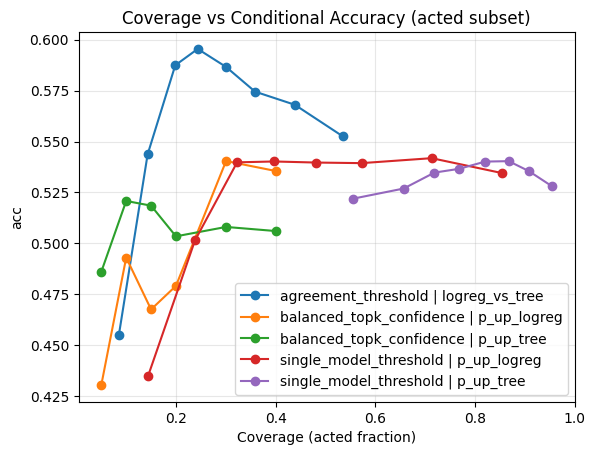

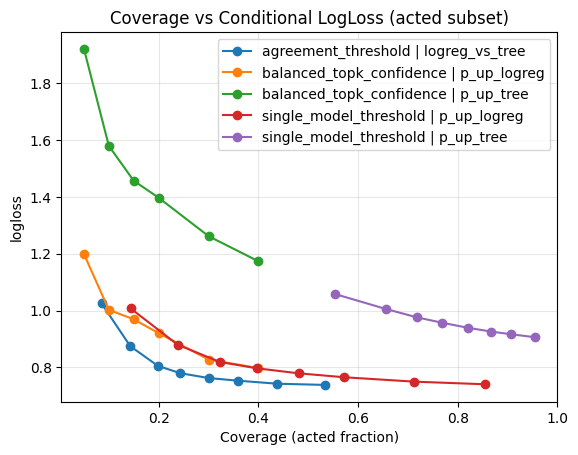

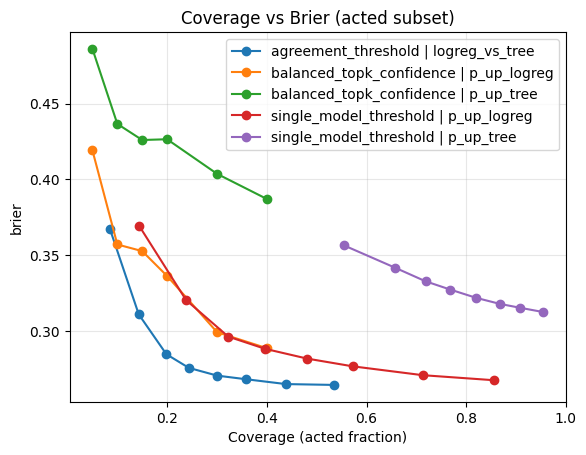

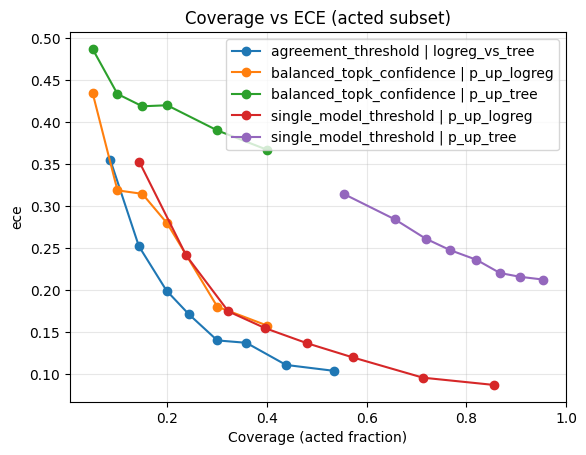

In [53]:
plot_coverage_metric(sweep, "acc", "Coverage vs Conditional Accuracy (acted subset)")
plot_coverage_metric(sweep, "logloss", "Coverage vs Conditional LogLoss (acted subset)")
plot_coverage_metric(sweep, "brier", "Coverage vs Brier (acted subset)")
plot_coverage_metric(sweep, "ece", "Coverage vs ECE (acted subset)")


## Stability through time

We select one operating point and evaluate time stability:
- Rolling 1Y conditional accuracy and logloss (acted subset)
- Enough acted trades per window to avoid noise

Default operating point:
- balanced_topk_confidence on logreg at 20% coverage


In [54]:
COVERAGE_TARGET = 0.20
MODEL_COL = "p_up_logreg"

p = df_pred[MODEL_COL]
conf = (p - 0.5).abs()

idx_up = df_pred.index[p >= 0.5]
idx_dn = df_pred.index[p < 0.5]

conf_up = conf.loc[idx_up].sort_values(ascending=False)
conf_dn = conf.loc[idx_dn].sort_values(ascending=False)

N = len(df_pred)
k_total = int(round(COVERAGE_TARGET * N))
k_up = k_total // 2
k_dn = k_total - k_up

chosen = conf_up.index[: min(k_up, len(conf_up))].union(conf_dn.index[: min(k_dn, len(conf_dn))])

act = pd.Series(0, index=df_pred.index, dtype=int)
act.loc[chosen] = np.where(p.loc[chosen] >= 0.5, 1, -1)

operating_point = {
    "policy": "balanced_topk_confidence",
    "model": MODEL_COL,
    "coverage_target": COVERAGE_TARGET,
    "realized_coverage": float((act != 0).mean()),
    "n_acted": int((act != 0).sum()),
}
operating_point


{'policy': 'balanced_topk_confidence',
 'model': 'p_up_logreg',
 'coverage_target': 0.2,
 'realized_coverage': 0.19972260748959778,
 'n_acted': 288}

In [55]:
from sklearn.metrics import accuracy_score, log_loss

WINDOW = 252  # ~1Y business days

def rolling_metrics(df_pred: pd.DataFrame, p_col: str, act: pd.Series, window: int = 252, min_acted: int = 30) -> pd.DataFrame:
    y = df_pred["y_true"].astype(int)
    p = df_pred[p_col]

    idx = df_pred.index
    rows = []

    for i in range(window, len(idx) + 1):
        sl = idx[i - window:i]
        a = act.loc[sl]
        mask = a != 0

        n_act = int(mask.sum())
        if n_act < min_acted:
            rows.append({"date": sl[-1], "n_acted": n_act, "acc": np.nan, "logloss": np.nan})
            continue

        y_a = y.loc[sl][mask].values
        p_a = p.loc[sl][mask].values
        yhat = (a.loc[sl][mask].values == 1).astype(int)

        rows.append({
            "date": sl[-1],
            "n_acted": n_act,
            "acc": float(accuracy_score(y_a, yhat)),
            "logloss": float(log_loss(y_a, np.c_[1 - p_a, p_a], labels=[0, 1])),
        })

    return pd.DataFrame(rows).set_index("date")

roll = rolling_metrics(df_pred, MODEL_COL, act, window=WINDOW, min_acted=30)
roll.tail()


,n_acted,acc,logloss
date,,,
2025-12-05,33,0.666667,0.642801
2025-12-08,32,0.687500,0.626781
2025-12-09,31,0.709677,0.610345
2025-12-10,30,0.733333,0.589874
2025-12-11,30,0.733333,0.589874


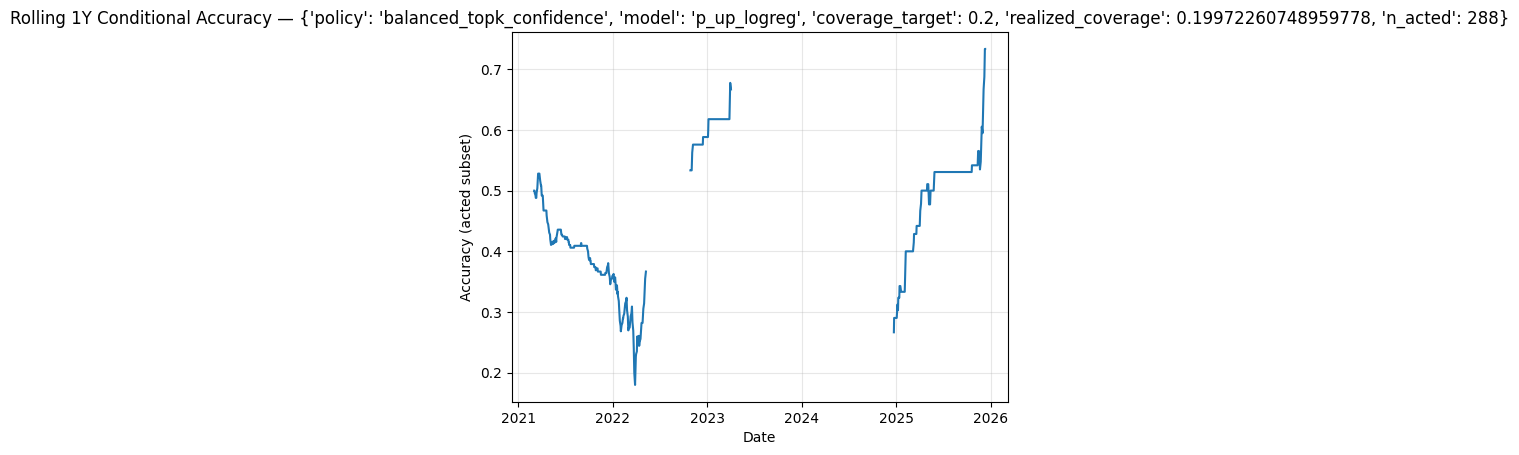

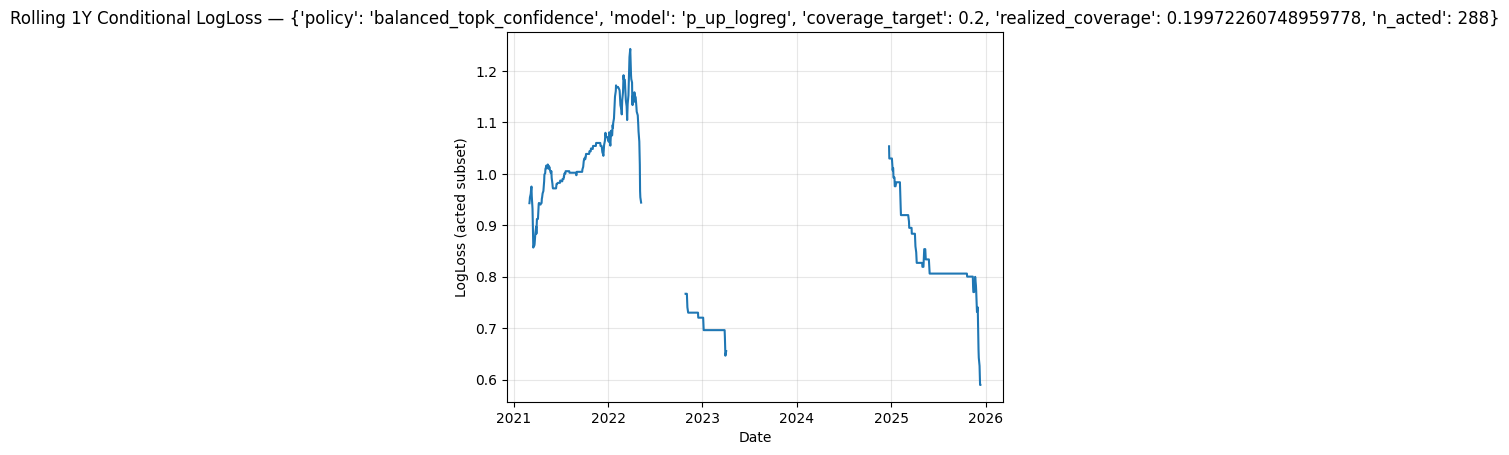

In [56]:
plt.figure()
plt.plot(roll.index, roll["acc"])
plt.title(f"Rolling 1Y Conditional Accuracy — {operating_point}")
plt.xlabel("Date")
plt.ylabel("Accuracy (acted subset)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(roll.index, roll["logloss"])
plt.title(f"Rolling 1Y Conditional LogLoss — {operating_point}")
plt.xlabel("Date")
plt.ylabel("LogLoss (acted subset)")
plt.grid(True, alpha=0.3)
plt.show()


In [60]:
df_eval = df_pred.copy()
df_eval["act"] = act
df_eval["year"] = df_eval.index.year

def year_metrics(g: pd.DataFrame, p_col: str) -> pd.Series:
    mask = g["act"] != 0
    n_act = int(mask.sum())
    if n_act == 0:
        return pd.Series({"n_acted": 0, "coverage": 0.0, "acc": np.nan, "logloss": np.nan})

    y_a = g.loc[mask, "y_true"].astype(int).values
    p_a = g.loc[mask, p_col].values
    yhat = (g.loc[mask, "act"].values == 1).astype(int)

    return pd.Series({
        "n_acted": n_act,
        "coverage": float(n_act / len(g)),
        "acc": float(accuracy_score(y_a, yhat)),
        "logloss": float(log_loss(y_a, np.c_[1 - p_a, p_a], labels=[0, 1])),
    })

rows = []
for yr, g in df_eval.groupby("year"):
    s = year_metrics(g, MODEL_COL)
    s.name = yr
    rows.append(s)
year_table = pd.DataFrame(rows)
year_table.index.name = "year"
year_table = year_table.sort_index()


year_table.sort_values("acc").head(5)


,n_acted,coverage,acc,logloss
year,,,,
2024,31.0,0.124000,0.290323,1.029802
2021,100.0,0.401606,0.350000,1.080748
2020,83.0,0.395238,0.518072,0.945884
2023,19.0,0.076613,0.578947,0.719033
2022,33.0,0.133065,0.606061,0.706363


In [58]:
def regime_slice_report(df_pred: pd.DataFrame, policy_name: str, model_col: str, t: float) -> pd.DataFrame:
    if "is_high_vol" not in df_pred.columns:
        return pd.DataFrame()

    out = []
    for regime_value, g in df_pred.groupby("is_high_vol"):
        act = apply_threshold_policy(g[model_col], t=t)
        m = evaluate_acted_subset(g["y_true"], g[model_col], act)
        m.update({
            "policy": policy_name,
            "model": model_col,
            "t": t,
            "is_high_vol": int(regime_value),
        })
        out.append(m)

    return pd.DataFrame(out)

regime_rows = []
if "is_high_vol" in df_pred.columns:
    # pick a couple of representative operating points
    for t in [0.56, 0.60, 0.65]:
        regime_rows.append(regime_slice_report(df_pred, "single_model_threshold", "p_up_logreg", t))
        regime_rows.append(regime_slice_report(df_pred, "single_model_threshold", "p_up_tree", t))

df_regime = pd.concat(regime_rows, ignore_index=True) if regime_rows else pd.DataFrame()
if not df_regime.empty:
    df_regime.to_csv(REGIME_CSV, index=False)


df_regime


,n,n_acted,coverage,acc,logloss,brier,ece,act_up_rate,act_down_rate,n_up_acted,n_down_acted,policy,model,t,is_high_vol
0,743,330,0.444145,0.530303,0.801538,0.293213,0.239270,0.687879,0.312121,227,103,single_model_threshold,p_up_logreg,0.56,0
1,699,495,0.708155,0.545455,0.741526,0.265484,0.116646,0.276768,0.723232,137,358,single_model_threshold,p_up_logreg,0.56,1
2,743,645,0.868102,0.547287,0.889299,0.305482,0.227230,0.437209,0.562791,282,363,single_model_threshold,p_up_tree,0.56,0
3,699,606,0.866953,0.533003,0.965349,0.330913,0.257728,0.447195,0.552805,271,335,single_model_threshold,p_up_tree,0.56,1
4,743,199,0.267833,0.482412,0.884783,0.327588,0.352466,0.783920,0.216080,156,43,single_model_threshold,p_up_logreg,0.60,0
5,699,373,0.533619,0.571046,0.750281,0.267049,0.118171,0.265416,0.734584,99,274,single_model_threshold,p_up_logreg,0.60,1
6,743,570,0.767160,0.545614,0.916517,0.313479,0.241995,0.429825,0.570175,245,325,single_model_threshold,p_up_tree,0.60,0
7,699,537,0.768240,0.527002,1.001585,0.341942,0.276717,0.450652,0.549348,242,295,single_model_threshold,p_up_tree,0.60,1
8,743,116,0.156124,0.379310,1.044072,0.394094,0.418977,0.956897,0.043103,111,5,single_model_threshold,p_up_logreg,0.65,0
9,699,227,0.324750,0.563877,0.796321,0.282613,0.169710,0.273128,0.726872,62,165,single_model_threshold,p_up_logreg,0.65,1


## Interpretation checklist

1) Coverage vs conditional accuracy:
- Do we see a monotonic improvement as coverage decreases?
- Is agreement gating meaningfully better than single-model gating?

2) Calibration at operating points:
- ECE should ideally decrease as we gate more aggressively.
- If ECE stays bad even at low coverage, calibration notebook (07) may help.

3) Directional balance:
- act_up_rate should not collapse to 0 or 1 for reasonable thresholds.

4) Regime diagnostics (if is_high_vol exists):
- Does performance concentrate in low vol only?
- Does coverage collapse in high vol (model unsure) vs still acting?
